In [1]:
import time
import pandas as pd
import numpy as np

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from datetime import datetime as dt, timedelta as td
# import models as m
from sqlalchemy import and_, func, or_, extract

epochs = [5, 30, 50, 100, 200, 500]
models = []

c:\users\kuno\miniconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Generar informacion de estaciones especificas training
start = dt(2015, 1, 1)
end = dt(2017, 1, 1)
minutes_delta = 15

with open('trips_train_cluster.csv', 'w') as file:
    while start < end:
        if start.isoweekday() not in range(1,6):
            start += td(days=1)
            continue
        if (start.hour == 0 and start.minute > 30) or start.hour < 5:
            start += td(minutes=minutes_delta)
            continue
        file.write("%s\n" % m.s.query(m.Trip).filter(and_(
            or_(m.Trip.departure_station.in_((272, 271, 267, 266)), m.Trip.arrival_station.in_((272, 271, 267, 266))),
            m.Trip.departure_time >= start.isoformat(),
            m.Trip.departure_time <= (start + td(minutes=minutes_delta)).isoformat(),
            )).count())
        start += td(minutes=minutes_delta)


In [4]:
# Generar informacion de estaciones especificas testing
start = dt(2017, 1, 1)
end = dt(2018, 1, 1)
minutes_delta = 15

with open('trips_test_cluster.csv', 'w') as file:
    while start < end:
        if start.isoweekday() not in range(1,6):
            start += td(days=1)
            continue
        if (start.hour == 0 and start.minute > 30) or start.hour < 5:
            start += td(minutes=minutes_delta)
            continue
        file.write("%s\n" % m.s.query(m.Trip).filter(and_(
            or_(m.Trip.departure_station.in_((272, 271, 267, 266)), m.Trip.arrival_station.in_((272, 271, 267, 266))),
            m.Trip.departure_time >= start.isoformat(),
            m.Trip.departure_time <= (start + td(minutes=minutes_delta)).isoformat(),
            )).count())
        start += td(minutes=minutes_delta)

In [5]:
def moving_test_window_preds(model, n_future_preds):
    ''' n_future_preds - Represents the number of future predictions we want to make
                        This coincides with the number of windows that we will move forward
                        on the test data
    '''
    preds_moving = []                                    # Use this to store the prediction made on each test window
    moving_test_window = [test_X[0,:].tolist()]          # Creating the first test window
    moving_test_window = np.array(moving_test_window)    # Making it an numpy array

    for i in range(n_future_preds):
        preds_one_step = model.predict(moving_test_window) # Note that this is already a scaled prediction so no need to rescale this
        preds_moving.append(preds_one_step[0,0]) # get the value from the numpy 2D array and append to predictions
        preds_one_step = preds_one_step.reshape(1,1,1) # Reshaping the prediction to 3D array for concatenation with moving test window
        moving_test_window = np.concatenate((moving_test_window[:,1:,:], preds_one_step), axis=1) # This is the new moving test window, where the first element from the window has been removed and the prediction  has been appended to the end

    preds_moving = scaler.inverse_transform(np.array(preds_moving).reshape(-1, 1))

    return preds_moving

In [ ]:
for epoch in epochs:
    # Load data
    train = pd.read_csv('trips_train_cluster.csv', header=None)
    test = pd.read_csv('trips_test_cluster.csv', header=None )
    scaler = MinMaxScaler(feature_range=(-1, 1))
    window_size = 78  # 78 steps in one day
    # normalize features
    scaled = scaler.fit_transform(train.values)
    train = pd.DataFrame(scaled)

    series_s = train.copy()
    for i in range(window_size):
        train = pd.concat([train, series_s.shift(-(i+1))], axis=1)

    train.dropna(axis=0, inplace=True)
    # Hacer lo mismo para los datos de prueba
    test = test.iloc[:24624, :]  # The rest are all 0s
    scaled = scaler.fit_transform(test.values)
    test = pd.DataFrame(scaled)

    series_s = test.copy()
    for i in range(window_size):
        test = pd.concat([test, series_s.shift(-(i+1))], axis = 1)

    test.dropna(axis=0, inplace=True)
    train = shuffle(train)
    train_X = train.iloc[:,:-1]
    train_y = train.iloc[:,-1]
    test_X = test.iloc[:,:-1]
    test_y = test.iloc[:,-1]
    train_X = train_X.values
    train_y = train_y.values
    test_X = test_X.values
    test_y = test_y.values
    train_X = train_X.reshape(train_X.shape[0],train_X.shape[1],1)
    test_X = test_X.reshape(test_X.shape[0],test_X.shape[1],1)

    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(input_shape=(window_size,1), output_dim=window_size, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(256))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation("linear"))
    model.compile(loss="mse", optimizer="adam")
    model.summary()
    # Train
    start = time.time()
    model.fit(train_X, train_y, batch_size=100, epochs=epoch, validation_split=0.1)
    print("> Compilation Time : ", time.time() - start)
    models.append(model)
    # Save
    model.save("%s_epochs_model_cluster.h5" % epoch)
    # Save first prediction
    preds_moving = moving_test_window_preds(model, 500)
    actuals = scaler.inverse_transform(test_y.reshape(-1, 1))
    mse = mean_squared_error(actuals[74:150], preds_moving[74:150])
    mae = mean_absolute_error(actuals[74:150], preds_moving[74:150])

    # Save data
    with open('f_cluster_%s_%s_%s.txt' % (epoch, mse, mae), 'w') as f:
        for i in preds_moving:
            f.write("%s\n" % i)

c:\users\lablogistica\appdata\local\continuum\miniconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
c:\users\lablogistica\appdata\local\continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(78, 1), return_sequences=True, units=78)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 78, 78)            24960     
_________________________________________________________________
dropout_1 (Dropout)          (None, 78, 78)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               343040    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 368,257
Trainable params: 368,257
Non-trainable params: 0
_________________________________________________________________
Trai

In [2]:
from keras.models import load_model

model = load_model('200_epochs_model.h5')

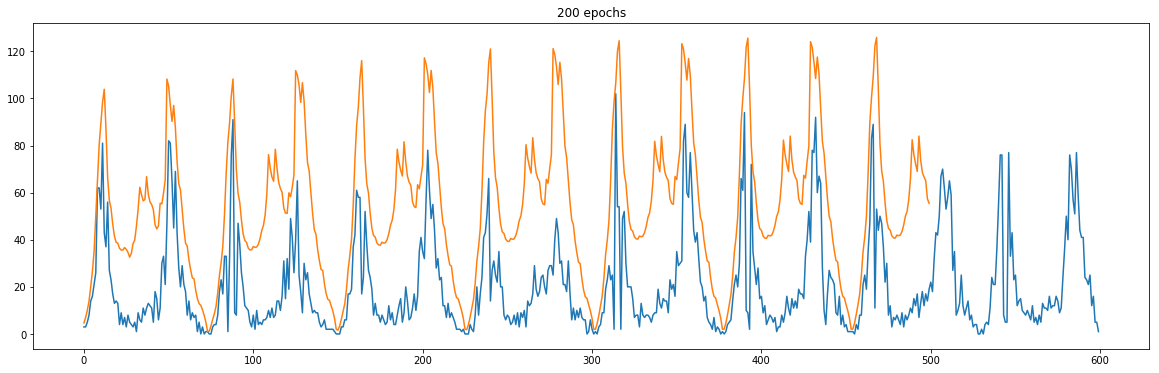

In [7]:
from matplotlib import pyplot

pyplot.figure(figsize=(20,6))
pyplot.plot(actuals[:600])
pyplot.plot(preds_moving[:600])
pyplot.title("200 epochs")
pyplot.show()

In [3]:
from keras.models import load_model
from matplotlib import pyplot

c:\users\kuno\miniconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


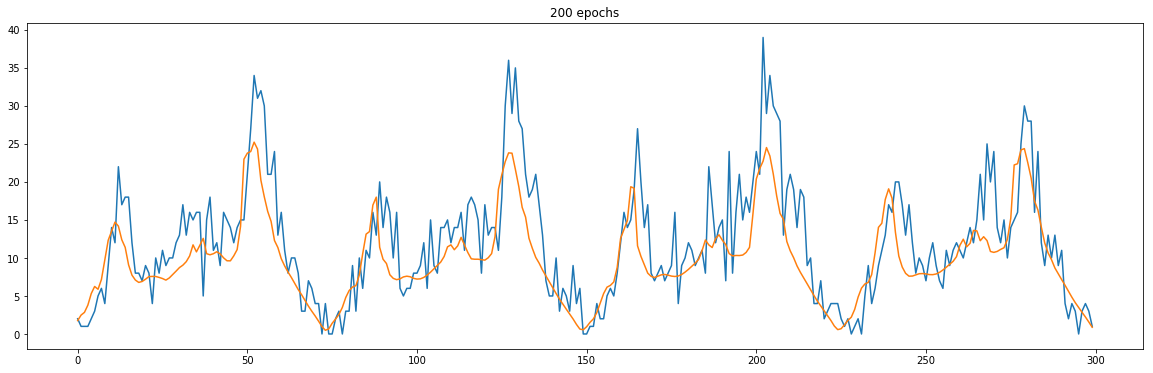

In [32]:
cluster = 8
epochs = 200
model = load_model('%s_epochs_model_cluster%s.h5' % (epochs, cluster))
train = pd.read_csv('cluster_data/trips_train_cluster%s.csv' % cluster, header=None)
test = pd.read_csv('cluster_data/trips_test_cluster%s.csv' % cluster, header=None )


scaler = MinMaxScaler(feature_range=(-1, 1))
window_size = 78  # 78 steps in one day
# normalize features
scaled = scaler.fit_transform(train.values)
train = pd.DataFrame(scaled)

series_s = train.copy()
for i in range(window_size):
    train = pd.concat([train, series_s.shift(-(i+1))], axis=1)

train.dropna(axis=0, inplace=True)
# Hacer lo mismo para los datos de prueba
test = test.iloc[:24624, :]  # The rest are all 0s
scaled = scaler.fit_transform(test.values)
test = pd.DataFrame(scaled)

series_s = test.copy()
for i in range(window_size):
    test = pd.concat([test, series_s.shift(-(i+1))], axis = 1)

test.dropna(axis=0, inplace=True)
train = shuffle(train)
train_X = train.iloc[:,:-1]
train_y = train.iloc[:,-1]
test_X = test.iloc[:,:-1]
test_y = test.iloc[:,-1]
train_X = train_X.values
train_y = train_y.values
test_X = test_X.values
test_y = test_y.values
train_X = train_X.reshape(train_X.shape[0],train_X.shape[1],1)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1],1)

preds_moving = moving_test_window_preds(model, 500)
actuals = scaler.inverse_transform(test_y.reshape(-1, 1))

pyplot.figure(figsize=(20,6))
pyplot.plot(actuals[:300])
pyplot.plot(preds_moving[:300])
pyplot.title("%s epochs" % epochs)
pyplot.show()

In [11]:
def predict_next(info, n):
    res = []
    for i in range(n):
        base = np.concatenate((scaler.fit_transform(info[i:78]), res)) if res else scaler.fit_transform(info[:78])
        pred = model.predict(np.array([base]))
        res.append(pred[0])
    return res

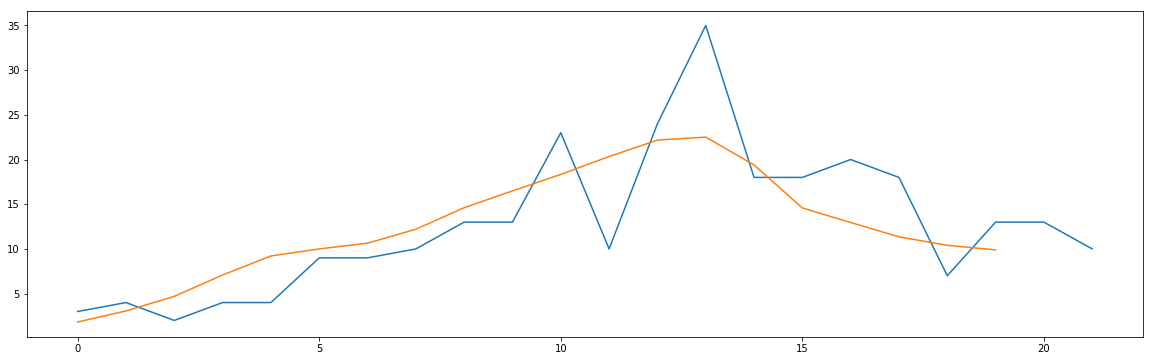

In [53]:
info = actuals[2050:2150]
pyplot.figure(figsize=(20,6))
pyplot.plot(info[78:])
pyplot.plot(scaler.inverse_transform(predict_next(info, 20)))
pyplot.show()

In [33]:
m1 = load_model('%s_epochs_model_cluster%s.h5' % (30, cluster))
m2 = load_model('%s_epochs_model_cluster%s.h5' % (50, cluster))
m3 = load_model('%s_epochs_model_cluster%s.h5' % (100, cluster))
m4 = load_model('%s_epochs_model_cluster%s.h5' % (200, cluster))

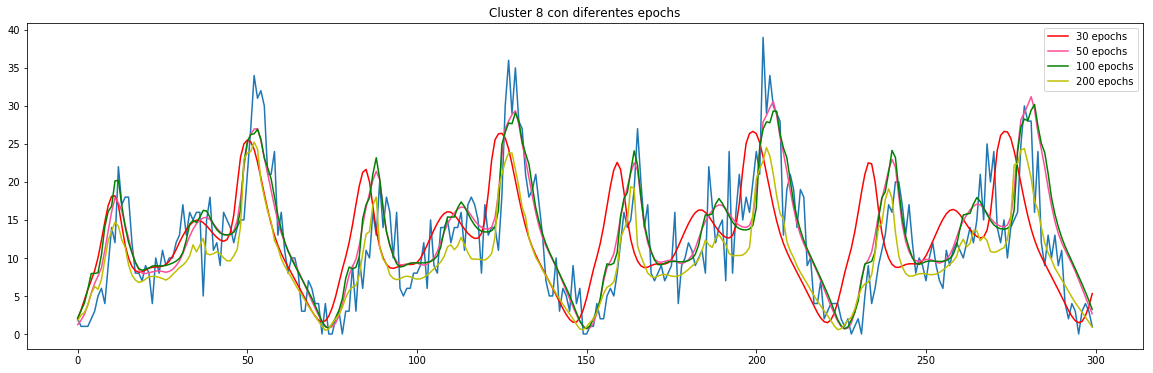

In [50]:
pyplot.figure(figsize=(20,6))
pyplot.plot(actuals[:300])
pyplot.plot(a, label="30 epochs", color="r")
pyplot.plot(b, label="50 epochs", color=(1, 0.3, 0.6))
pyplot.plot(c, label="100 epochs", color="g")
pyplot.plot(d, label="200 epochs", color="y")
pyplot.title("Cluster 8 con diferentes epochs")
pyplot.legend()
pyplot.show()

In [45]:
a = moving_test_window_preds(m1, 500)[:300]
b = moving_test_window_preds(m2, 500)[:300]
c = moving_test_window_preds(m3, 500)[:300]
d = moving_test_window_preds(m4, 500)[:300]

In [51]:
print("30 epochs.\tMSE: %s\tMAE: %s" % (mean_squared_error(actuals[:300], a), mean_absolute_error(actuals[:300], a)) )
print("50 epochs.\tMSE: %s\tMAE: %s" % (mean_squared_error(actuals[:300], b), mean_absolute_error(actuals[:300], b)) )
print("100 epochs.\tMSE: %s\tMAE: %s" % (mean_squared_error(actuals[:300], c), mean_absolute_error(actuals[:300], c)) )
print("200 epochs.\tMSE: %s\tMAE: %s" % (mean_squared_error(actuals[:300], d), mean_absolute_error(actuals[:300], d)) )

30 epochs.	MSE: 47.86540178954771	MAE: 5.39564008752505
50 epochs.	MSE: 16.52319792382705	MAE: 3.1541734021902084
100 epochs.	MSE: 18.095638355582725	MAE: 3.2299707897504173
200 epochs.	MSE: 25.22412443765576	MAE: 3.80746980547905
